In [50]:
import tensorflow as tf
import os

from bing_image_downloader import downloader

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import random

import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

np.set_printoptions(suppress=True)

In [51]:
# downloader.download("Hagia Sophia — Istanbul, Turkey", limit=250, output_dir="images")
# downloader.download("Dancing House — Prague, Czech Republic", limit=250, output_dir="images")
# downloader.download("Château de Chenonceau — Chenonceaux, France", limit=250, output_dir="images")
# downloader.download("The Colosseum — Rome, Italy", limit=250, output_dir="images")
# downloader.download("St. Basil’s Cathedral — Moscow, Russia", limit=250, output_dir="images")

In [52]:
data_dir = "images"
image_exts = ["jpeg", "jpg", "bmp", "png"]

In [53]:
os.listdir(data_dir)

['Chateau de Chenonceau',
 'Dancing House',
 'Hagia Sophia',
 'St. Basils Cathedral',
 'The Colosseum']

In [54]:
os.listdir(os.path.join(data_dir,"Chateau de Chenonceau"))

['Image_1.jpg',
 'Image_10.JPG',
 'Image_100.jpg',
 'Image_101.jpg',
 'Image_102.jpg',
 'Image_103.jpg',
 'Image_104.JPG',
 'Image_105.jpg',
 'Image_106.jpg',
 'Image_107.JPG',
 'Image_108.jpg',
 'Image_11.jpg',
 'Image_110.jpg',
 'Image_111.jpg',
 'Image_112.jpg',
 'Image_113.jpg',
 'Image_114.jpg',
 'Image_115.jpg',
 'Image_117.jpg',
 'Image_118.jpg',
 'Image_12.jpeg',
 'Image_121.jpg',
 'Image_123.jpg',
 'Image_124.jpg',
 'Image_125.jpg',
 'Image_128.jpg',
 'Image_13.jpg',
 'Image_130.jpg',
 'Image_132.jpg',
 'Image_133.jpg',
 'Image_135.JPG',
 'Image_136.jpg',
 'Image_137.jpg',
 'Image_138.jpg',
 'Image_139.jpg',
 'Image_14.jpg',
 'Image_140.jpg',
 'Image_142.jpg',
 'Image_143.jpg',
 'Image_147.jpg',
 'Image_148.jpg',
 'Image_149.jpg',
 'Image_15.jpg',
 'Image_150.jpg',
 'Image_151.jpg',
 'Image_152.jpg',
 'Image_154.jpg',
 'Image_156.jpg',
 'Image_157.jpg',
 'Image_16.jpeg',
 'Image_17.jpg',
 'Image_18.JPG',
 'Image_19.jpg',
 'Image_2.jpeg',
 'Image_20.jpg',
 'Image_21.jpg',
 'Ima

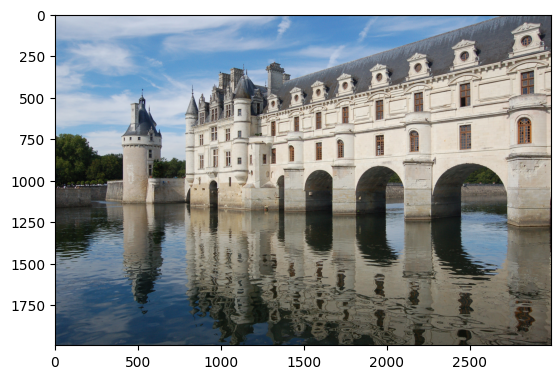

(1993, 2990, 3)

In [55]:
img = cv2.imread(os.path.join(data_dir, "Chateau de Chenonceau", "Image_10.jpg"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
img.shape

In [56]:
data = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,   
)
data

Found 628 files belonging to 5 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [57]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000018F9C9E8690>)

In [58]:
batch = data_iterator.next()
len(batch)
batch[0].shape, batch[1].shape

((32, 256, 256, 3), (32, 5))

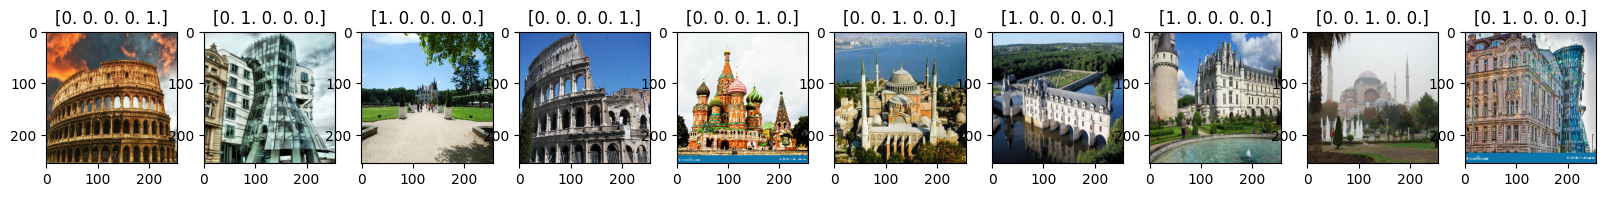

In [59]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    validation_split=0.3,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,
)
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    validation_split=0.3,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,   
)
tf.data.experimental.cardinality(val_test_ds).numpy()

Found 628 files belonging to 5 classes.
Using 440 files for training.
Found 628 files belonging to 5 classes.
Using 188 files for validation.


6

In [61]:
total_samples = val_test_ds.cardinality().numpy()
val_num = int(0.7*total_samples)
test_num = int(0.3*total_samples)
val_num, test_num

(4, 1)

In [62]:
val_ds = val_test_ds.take(val_num)
test_ds = val_test_ds.skip(val_num).take(test_num)
val_ds, test_ds

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [63]:
main_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    labels="inferred",
    seed=123,
    label_mode="categorical",
    image_size=(256, 256),
    batch_size=32,
)

images_count_val = [0,0,0,0,0]
images_count_train = [0,0,0,0,0]

val__images = []
val__labels = []

test_images = []
test_labels = []

train_images = []
train_labels = []

for image,label in main_ds.unbatch():

    if images_count_train[np.argmax(label.numpy())] < 85:
        train_images.append(image)
        train_labels.append(label)
        images_count_train[np.argmax(label.numpy())] = images_count_train[np.argmax(label.numpy())] + 1

    elif images_count_val[np.argmax(label.numpy())] < 15:
        val__images.append(image)
        val__labels.append(label)
        images_count_val[np.argmax(label.numpy())] = images_count_val[np.argmax(label.numpy())] + 1
    
    else:
        test_images.append(image)
        test_labels.append(label)

train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds_balanced = train_ds_balanced.shuffle(100)
train_ds_balanced = train_ds_balanced.batch(32)

val_ds_balanced = tf.data.Dataset.from_tensor_slices((val__images, val__labels))
val_ds_balanced = val_ds_balanced.shuffle(100)
val_ds_balanced = val_ds_balanced.batch(32)

test_ds_balanced = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds_balanced = test_ds_balanced.shuffle(100)
test_ds_balanced = test_ds_balanced.batch(32)

train_ds_balanced

Found 628 files belonging to 5 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [64]:
class_counts = {}

for _, labels in val_ds_balanced:
    for label in labels.numpy():
        class_idx = label.argmax()  
        if class_idx not in class_counts:
            class_counts[class_idx] = 1
        else:
            class_counts[class_idx] += 1

for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")


Class 4: 15 samples
Class 2: 15 samples
Class 1: 15 samples
Class 3: 15 samples
Class 0: 15 samples


In [65]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # RandomFlip layer
        tf.keras.layers.RandomTranslation(
            height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)
        ),  # RandomTranslation layer
        tf.keras.layers.RandomRotation(factor=0.2),  # RandomRotation layer
        # tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3)),  # RandomZoom layer
        tf.keras.layers.RandomContrast(factor=(0.2)),  # RandomContrast layer
        tf.keras.layers.RandomBrightness(factor=(0.2)),  # RandomBrightness layer
    ]
)
AUTOTUNE = tf.data.AUTOTUNE
train_ds_augmented = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)
train_ds_augmented2 = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)
train_ds_augmented3 = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)
train_ds_augmented4 = train_ds_balanced.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
)

In [66]:
train_ds_merged = train_ds_balanced.concatenate(train_ds_augmented)
train_ds_merged = train_ds_merged.concatenate(train_ds_augmented2)
train_ds_merged

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [67]:
classes = np.array([0, 1, 2, 3, 4])
y = np.array([label.numpy() for _, label in train_ds_merged.unbatch()])
y = np.argmax(y, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights

array([1., 1., 1., 1., 1.])

In [68]:
class_weights_dict = {}
for i, weight in enumerate(class_weights):
    class_weights_dict[i] = weight
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

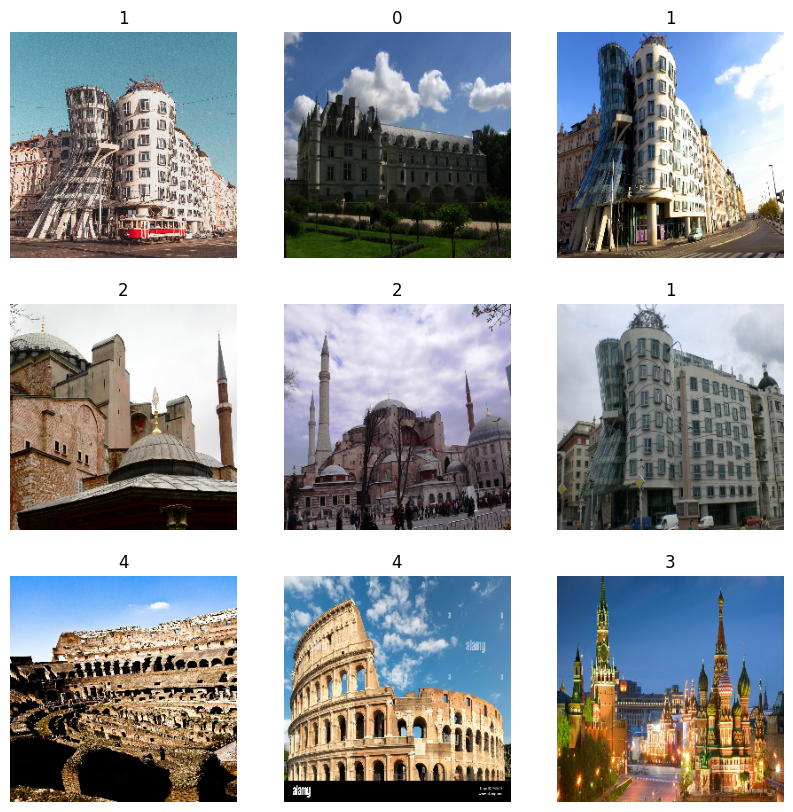

In [69]:
class_names = [0,1,2,3,4]
plt.figure(figsize=(10, 10))
for images, labels in train_ds_merged.take(4):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy()) 
        plt.title(class_names[int(label_index)])  
        plt.axis("off")

In [70]:
train_ds_merged = train_ds_merged.map(lambda x, y: (x/255, y))
val_ds_balanced = val_ds_balanced.map(lambda x, y: (x/255, y))
test_ds_balanced = test_ds_balanced.map(lambda x, y: (x/255, y))

sample = val_ds_balanced.as_numpy_iterator().next()
sample[0].max()

1.0

In [71]:
model = Sequential()

model.add(Conv2D(16, 7, activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))  

model.add(Conv2D(32, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))  

model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))  

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))  

model.add(Dense(units=5, activation="softmax"))

c:\Users\Nikola\anaconda3\envs\mlenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
model.compile("adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [73]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,207,477 (16.05 MB)

 Trainable params: 4,207,477 (16.05 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
callbacks = [
        EarlyStopping(patience=10, monitor="val_loss", verbose=1),
        TensorBoard(log_dir="logs", histogram_freq=1),
    ]
# hist = model.fit(train_ds_merged, epochs=100, validation_data=val_ds_balanced, class_weight=class_weights_dict, callbacks=callbacks)
model = keras.models.load_model('model.keras')
# model.save('model.keras')

In [75]:
true_labels = []
predicted_labels = []

for batch in test_ds_balanced:
    X, y = batch
    yhat = model.predict(X)
    true_labels.extend(np.argmax(y, axis=1))
    predicted_labels.extend(np.argmax(yhat, axis=1))

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
F1 = f1_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1: ", F1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Accuracy: 0.8828125
Precision: 0.790873015873016
Recall: 0.906257747108811
F1:  0.8275413831956108


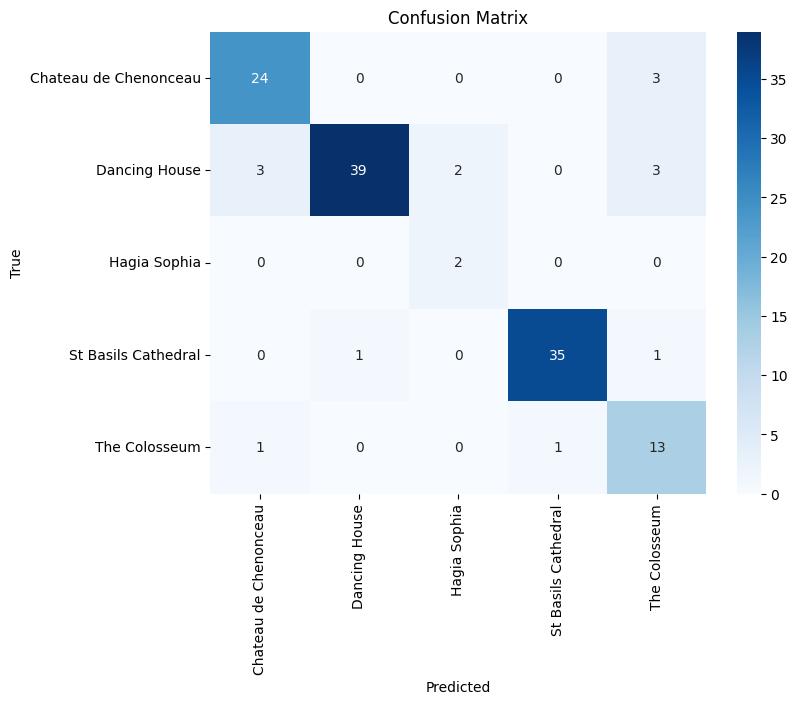

In [76]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[
        "Chateau de Chenonceau",
        "Dancing House",
        "Hagia Sophia",
        "St Basils Cathedral",
        "The Colosseum",
    ],
    yticklabels=[
        "Chateau de Chenonceau",
        "Dancing House",
        "Hagia Sophia",
        "St Basils Cathedral",
        "The Colosseum",
    ],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[0.02102735 0.09324895 0.14964983 0.00265115 0.7334227 ]]
The Colosseum


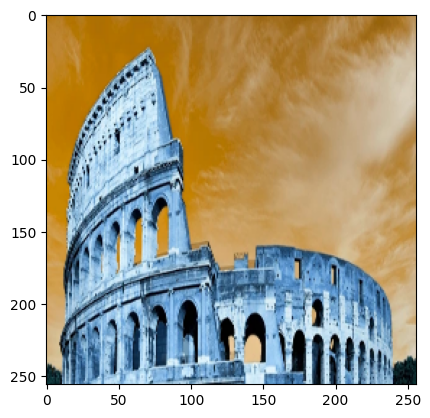

In [77]:
# Testing on images from external sources
img = cv2.imread("C:/Users/Nikola/Desktop/rome-italy-arches-archictecture-colosseum-600nw-2103889967.webp")
image_resized = tf.image.resize(img,(256,256))

print(np.expand_dims(image_resized/255,0).shape)
yhat = model.predict(np.expand_dims(image_resized/255,0))
print(yhat)

class_index = yhat.argmax(axis=1)
if class_index == 0:
    print("Chateau de Chenonceau")
elif class_index == 1:
    print("Dancing House")
elif class_index == 2:
    print("Hagia Sophia")
elif class_index == 3:
    print("St Basils Cathedral")
elif class_index == 4:
    print("The Colosseum")

plt.imshow(image_resized.numpy().astype(int))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


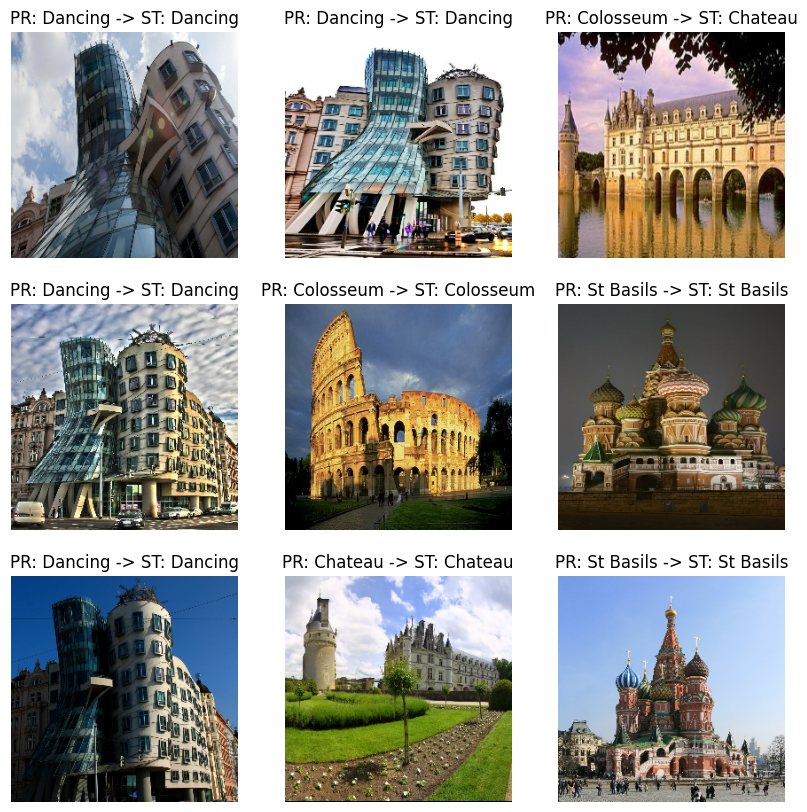

In [78]:
class_names = ["Chateau", "Dancing", "Hagia", "St Basils", "Colosseum"]
plt.figure(figsize=(10, 10))
for images, labels in test_ds_balanced.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        label_index = np.argmax(model.predict(np.expand_dims(images[i],0))) #
        plt.title(f"PR: {class_names[int(label_index)]} -> ST: {class_names[np.argmax(labels[i].numpy())]}")  
        plt.axis("off")